In [75]:
from fastai.text import *
import html
from fastai.lm_rnn import *

In [2]:
BOS = 'xbos'
FLD = 'xfld'
PATH = Path('data/aclImdb')

In [3]:
CLAS_PATH = Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH = Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

In [4]:
CLASSES = ['neg','pos','unsup']

In [5]:
def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r').read())
            labels.append(idx)
    return np.array(texts),np.array(labels)

trn_texts,trn_labels = get_texts(PATH/'train')
val_texts,val_labels = get_texts(PATH/'test')

In [6]:
len(trn_texts), len(val_texts)

(75000, 25000)

In [7]:
col_names = ['labels','text']

In [8]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [9]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

In [10]:
df_trn = pd.DataFrame({'text': trn_texts,'labels':trn_labels},columns=col_names)
df_val = pd.DataFrame({'text': val_texts,'labels': val_labels},columns=col_names)

In [11]:
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

In [12]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
np.concatenate([trn_texts,val_texts]),test_size=0.1)

In [13]:
len(trn_texts),len(val_texts)

(90000, 10000)

In [14]:
df_trn = pd.DataFrame({'text':trn_texts,'labels':[0]*len(trn_texts)},columns=col_names)
df_val = pd.DataFrame({'text':val_texts,'labels':[0]*len(val_texts)},columns=col_names)

In [15]:
df_trn.to_csv(LM_PATH/'train.csv',header=False,index=False)
df_val.to_csv(LM_PATH/'test.csv',header=False,index=False)

In [16]:
# LM Token

In [17]:
chunksize=24000

In [18]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [19]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok,list(labels)

In [20]:
def get_all(df,num_labels):
    tok,labels=[],[]
    for i,r in enumerate(df):
        print(i)
        tok_,labels_ = get_texts(r,num_labels)
        tok+=tok_;
        labels+=labels_
    return tok,labels

In [21]:
df_trn = pd.read_csv(LM_PATH/'train.csv',header=None,chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv',header=None,chunksize=chunksize)

In [22]:
tok_trn, trn_labels = get_all(df_trn,1)
tok_val, val_labels = get_all(df_val,1)

0
1
2
3
0


In [23]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [24]:
np.save(LM_PATH/'tmp'/'tok_trn.npy',tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy',tok_val)

In [25]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [26]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 1209064),
 ('.', 992727),
 (',', 986207),
 ('and', 587745),
 ('a', 584094),
 ('of', 525582),
 ('to', 486136),
 ('is', 393630),
 ('it', 342198),
 ('in', 338373),
 ('i', 308299),
 ('this', 270562),
 ('that', 261221),
 ('"', 237758),
 ("'s", 221987),
 ('-', 188394),
 ('was', 180635),
 ('\n\n', 179407),
 ('as', 166361),
 ('with', 159483),
 ('for', 159059),
 ('movie', 157659),
 ('but', 150712),
 ('film', 144021),
 ('you', 124072)]

In [27]:
max_vocab = 60000
min_freq = 2

In [28]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0,'_pad_')
itos.insert(1,'_unk_')

In [29]:
stoi = collections.defaultdict(lambda: 0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [30]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [31]:
np.save(LM_PATH/'tmp'/'trn_ids.npy',trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy',val_lm)
pickle.dump(itos,open(LM_PATH/'tmp'/'itos.pkl','wb'))

In [32]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl','rb'))

In [33]:
vs = len(itos)
vs,len(trn_lm)

(60002, 90000)

In [79]:
! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

--2018-06-14 15:49:48--  http://files.fast.ai/models/wt103/
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘data/aclImdb/models/wt103/index.html’

100%[======================================>] 857         --.-K/s   in 0s      

2018-06-14 15:49:49 (238 MB/s) - ‘data/aclImdb/models/wt103/index.html’ saved [857/857]

Loading robots.txt; please ignore errors.
--2018-06-14 15:49:49--  http://files.fast.ai/robots.txt
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 404 Not Found
2018-06-14 15:49:50 ERROR 404: Not Found.

--2018-06-14 15:49:50--  http://files.fast.ai/models/wt103/?C=N;O=D
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘data/aclImdb/models/wt103/index.html?C=N;O=D’

100%[==================

In [34]:
emb_sz,nh,nl = 400,1150,3

In [35]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [36]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage,loc: storage)

In [37]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [38]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [39]:
new_w = np.zeros((vs,emb_sz),dtype=np.int32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [40]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [41]:
# Language Model

In [42]:
wd = 1e-7
bptt = 70
bs = 40
opt_fn = partial(optim.Adam, betas=(0.8,0.99))

In [43]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm),bs,bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm),bs,bptt)
md = LanguageModelData(PATH,1,vs,trn_dl,val_dl,bs=bs,bptt=bptt)

In [44]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [45]:
learner = md.get_model(opt_fn,emb_sz,nh,nl,
                      dropouti = drops[0],dropout=drops[1],wdrop=drops[2],dropoute=drops[3],dropouth=drops[4])

learner.metrics = [accuracy]

In [46]:
learner.model.load_state_dict(wgts)

In [47]:
lr=1e-3
lrs=lr

In [48]:
learner.lr_find(start_lr=lr/8,end_lr=lrs*10,linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      4.831025   4.673138   0.242037  



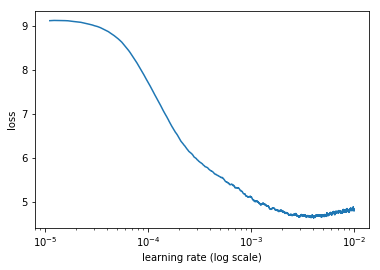

In [49]:
learner.sched.plot()

In [50]:
learner.fit(lrs,1,wds=wd,use_clr=(20,10),cycle_len=15)

epoch      trn_loss   val_loss   accuracy                     
    0      4.477278   4.322508   0.27532   
    1      4.272848   4.158346   0.288188                     
    2      4.171133   4.094673   0.294321                     
    3      4.125019   4.061459   0.297598                     
    4      4.10018    4.040561   0.300046                     
    5      4.140261   4.022758   0.301827                     
    6      4.035982   4.013479   0.303036                     
    7      4.038082   4.001025   0.304446                     
    8      4.075504   3.988246   0.305873                     
    9      4.059599   3.980933   0.30657                      
    10     3.975391   3.976652   0.307561                     
    11     3.947781   3.970363   0.308422                     
    12     4.009988   3.960315   0.309542                     
    13     3.949061   3.957949   0.310004                     
    14     3.910018   3.955381   0.310544                     



[3.9553813126662014, 0.3105440429911124]

In [53]:
learner.save('lm1')

In [54]:
learner.save_encoder('lm1_enc')

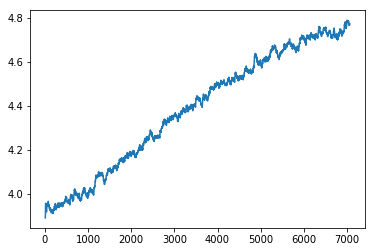

In [55]:
learner.sched.plot_loss()

In [ ]:
learner.load('lm1')

In [ ]:
learner.load_encoder('lm1_enc')

In [50]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv',header=None,chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [52]:
tok_trn, trn_labels = get_all(df_trn,1)
tok_val, val_labels = get_all(df_val,1)

0
1
0
1


In [53]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy',tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels',val_labels)

In [54]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [56]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [57]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [60]:
np.save(CLAS_PATH/'tmp'/'tok_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy',val_clas)

## Classifier

In [61]:
trn_clas = np.load(CLAS_PATH/'tmp'/'tok_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [63]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [93]:
bptt,emb_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam,betas=(0.8,0.99))
bs = 24

In [94]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c = int(trn_labels.max())+1

In [95]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas,val_labels)
trn_samp = SortishSampler(trn_clas,key=lambda x: len(trn_clas[x]), bs = bs//2)
val_samp = SortishSampler(val_clas, key=lambda x: len(val_clas[x]), bs = bs//2)
trn_dl = DataLoader(trn_ds,bs//2,transpose=True, num_workers=1, pad_idx=1,sampler=trn_samp)
val_dl = DataLoader(val_ds, bs//2,transpose=True, num_workers=1, pad_idx=1,sampler=val_samp)
md = ModelData(PATH,trn_dl,val_dl)

In [96]:
dropouts = np.array([0.4,0.5,0.05,0.3,0.1])*0.5

In [97]:
m = get_rnn_classifer(bptt,20*70,c,vs,emb_sz=emb_sz,n_hid=nh,n_layers=nl,pad_token=1,
                      layers=[emb_sz*3,50,c], drops=[dropouts[4],0.1],
                      dropouti=dropouts[0],wdrop=dropouts[1],dropoute=dropouts[2],dropouth=dropouts[3])

In [98]:
opt_fn = partial(optim.Adam, betas=(0.7,0.99))

In [99]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2,beta=1)
learn.clip=25
learn.metrics = [accuracy]

In [100]:
lrs = np.array([1e-4,1e-4,1e-4,1e-3,1e-3])

In [101]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [102]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.257273   0.225858   0.90944   



[0.22585821365624667, 0.9094400035953522]

In [103]:
learn.save('clas_0')

In [104]:
learn.load('clas_0')

In [105]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                      
    0      0.244575   0.209588   0.91588   
    1      0.217156   0.190415   0.92512                       
    2      0.202151   0.180527   0.92952                       
    3      0.17523    0.181884   0.92924                       
    4      0.155282   0.181546   0.93244                       
    5      0.134034   0.186079   0.93056                       
    6      0.153607   0.187012   0.93128                        
    7      0.122899   0.194659   0.93124                        
    8      0.10508    0.196284   0.93348                        
    9      0.082601   0.212944   0.93232                        
    10     0.067472   0.225588   0.93088                        
    11     0.08839    0.229665   0.92952                        
    12     0.052749   0.239308   0.93032                        
    13     0.065296   0.239576   0.9316                         



[0.23957583338039753, 0.9316000045490265]

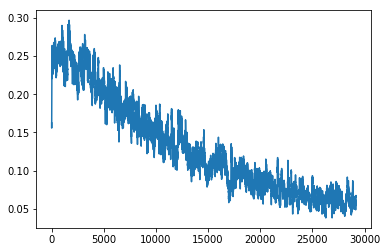

In [107]:
learn.sched.plot_loss()

In [108]:
learn.save('clas_2')